In [1]:
from satpy import Scene
from glob import glob
import xarray as xr
import numpy as np
import xesmf as xe
from pyresample import create_area_def

/home/xin/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
f_tropomi = glob('../data/tropomi/S5P_NRTI_L2__NO2____20220701T2041*.nc')
scn_tropomi = Scene(f_tropomi, reader='tropomi_l2')
scn_tropomi.load(['assembled_lon_bounds', 'assembled_lat_bounds', 'nitrogendioxide_tropospheric_column'])

# fix bug of loading ancillary variables
scn_tropomi['nitrogendioxide_tropospheric_column'].attrs['ancillary_variables'] = []

Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure


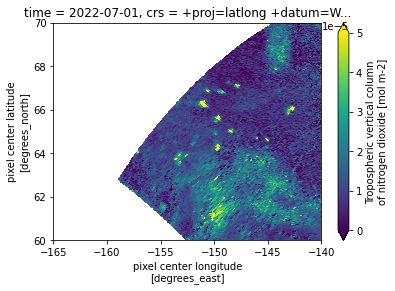

In [3]:
scn_tropomi['nitrogendioxide_tropospheric_column'].plot(x='longitude', y='latitude', xlim=(-165, -140), ylim=(60, 70), cmap='viridis', vmin=0, vmax=5e-5)

## pyresample EWA resampler

In [4]:
# define the interested area
alaska_rect = create_area_def('alaska_Rectilinear',
                              {'proj': 'longlat', 'datum': 'WGS84'},
                              area_extent=[-165, 60, -140, 70],
                              resolution=0.01,
                              units='degrees',
                              description='Alaska 0.01x0.01 degree lat-lon grid')

In [5]:
new_scn = scn_tropomi.resample(alaska_rect, resampler='ewa', rows_per_scan=scn_tropomi['nitrogendioxide_tropospheric_column'].shape[0], weight_distance_max=1, weight_delta_max=8)

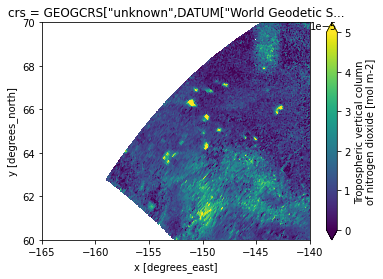

In [6]:
new_scn['nitrogendioxide_tropospheric_column'].plot(cmap='viridis',  vmin=0, vmax=5e-5)

## xESMF conservative regridder

In [7]:
ds_tropomi = scn_tropomi.to_xarray_dataset()
ds_tropomi = ds_tropomi.rename({'longitude': 'lon', 'latitude': 'lat'})
ds_tropomi.coords['lon_b'] = scn_tropomi['assembled_lon_bounds'].rename({'y_bounds': 'y_b', 'x_bounds': 'x_b'})
ds_tropomi.coords['lat_b'] = scn_tropomi['assembled_lat_bounds'].rename({'y_bounds': 'y_b', 'x_bounds': 'x_b'})
ds_tropomi["mask"] = xr.where(~np.isnan(ds_tropomi["nitrogendioxide_tropospheric_column"]), 1, 0)

In [8]:
xe_grid = xe.util.grid_2d(-165, -140, 0.1, 60, 70, 0.01)

# you can accelerate the regrid next time
#   https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html
regridder = xe.Regridder(ds_tropomi, xe_grid, 'conservative_normed')

In [9]:
no2_regrid_xe = regridder(ds_tropomi['nitrogendioxide_tropospheric_column'].load())

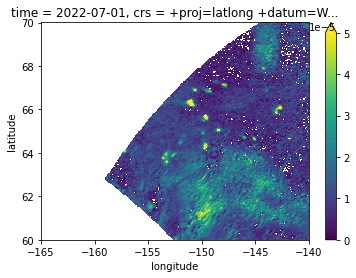

In [10]:
no2_regrid_xe.where(no2_regrid_xe > 0).plot(x='lon', y='lat', cmap='viridis', vmin=0, vmax=5e-5)